# Targets Assessor
This notebook aims to injest a list of source descriptions and observation criteria from the STM effort, applying appropriate metric tools to assess against the critera for a list of mission concept descriptions.

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/binaryResolutionSources.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
!mkdir -p '../plots/'

# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import constants
import metrics
import sources
import concepts
import subsystems
import background
import pandas as pd
from glob import glob
import re
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

### Edit target info:

In [2]:
m1,m2=1e6,1e4
z=4.0
#give f0 value if not a chirp
f0=None
#optional specification of end of observation
timecut=None
#observation targets
res_req_arcsec=10.0
SNR_req=5

### Define the set of concepts
Here we load in a set of the pre-defined concepts, or you can define your own

In [3]:
missionNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA',
    'ALIA',
    'ALIAlowL')
missions=[concepts.menu[mission] for mission in missionNames]

for mission in missions:
    mission=background.add2model(mission)
#model = concepts.LISACBE.copy()
#modelName = model.get('label')
#model = background.add2model(model)     # add galactic background model

In [4]:
# make source dictionary
objectiveList=[]
minimumSNR=5
obj={}
obj['label']='your source'
obj['m1']=m1*(1+z)#convert to redshifted mass
obj['m2']=m2*(1+z)#convert to redshifted mass
dist=cosmo.luminosity_distance(z).to(u.kpc).value
obj['dl']=dist
if f0 is None: 
    obj['type']='chirp'
    if timecut is not None and np.isfinite(timecut):
        obj['timecut']=timecut
else: 
    obj['type']='CW'
    obj['f0']=row['f0']

#Now add the conditions
conditions={}
if res_req_arcsec is not None and np.isfinite(res_req_arcsec):
    conditions['resolution']=res_req_arcsec/3600/180*np.pi #convert arcsec to rad
snr=minimumSNR
if SNR_req is not None and np.isfinite(SNR_req): snr=max([minimumSNR,SNR_req])
conditions['SNR']=snr
obj['conditions']=conditions
objectiveList.append(obj)
    

### Perform the observations and assessment
We first compute the SNR and then the angular resolution

In [5]:

for mission in missions:
    obs = list()
    for s in objectiveList:
        ob = metrics.getSourceSnr(s,mission,-4.0*constants.year)
        ob = metrics.getResolution(ob)
        #Perform the assessment
        #The assessment is based on the ratio of the estimated capability to the objective for each of
        #resolution and SNR, with <=1 meaning that the objective is met
        #A total is based on the worst of those present
        conditions=s['conditions']
        assessment={}
        alleps=[]
        print(conditions)
        if 'SNR' in conditions:
            eps=ob['SNR']/conditions['SNR']
            assessment['eps_SNR']=eps
            alleps.append(eps)
        if 'resolution' in conditions:
            eps=conditions['resolution']/ob['Angular Resolution']
            #print(ob['Angular Resolution'],conditions['resolution'],eps)
            assessment['eps_res']=eps
            alleps.append(eps)
        #print('alleps',alleps)
        if len(alleps)>0: assessment['eps']=max(alleps)
        ob['assessment']=assessment    
        obs.append(ob)
        
    mission['obs']=obs
    


mtot =  24, eta = 0.0098, ds = 3.8e+18, T = -1.3e+08
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 4.84813681109536e-05, 'SNR': 5}
mtot =  24, eta = 0.0098, ds = 3.8e+18, T = -1.3e+08
{'resolution': 4.84813681109536e-05, 'SNR': 5}
mtot =  24, eta = 0.0098, ds = 3.8e+18, T = -1.3e+08
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
{'resolution': 4.84813681109536e-05, 'SNR': 5}
mtot =  24, eta = 0.0098, ds = 3.8e+18, T = -1.3e+08
QE: 0.8156855160078964
P_Rx: 1.3031119162595927e-10
sqSn_shot: 7.038237778863639e-12
QE: 0.8156855160078964
P_Rx: 1.3031119162595927e-10
sqSn_shot: 7.038237778863639e-12
{'resolution': 4.84813681109536e-05, 'SNR': 5}
mtot =  24, eta = 0.0098, ds = 3.8e+18, T = -1.3e+08
QE: 0.5599286380854205
P_Rx: 9.0835347052

### Show assessments

In [6]:
#Make a dataframe with the results
objectiveNames=['your target']
data=np.zeros((len(obs),len(missions)))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps',None)

adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=missionNames)
#adf=adf.dropna()
def shrink():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")])
]
def zoom():
    return [
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn').set_properties(**{'max-width': '120px', 'font-size': '10pt'})
s=s.set_caption("Net performance")
#s=s.set_table_styles(shrink())
#s=s.set_table_styles(shrink()+zoom())

display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
your target,74.892208,67.351158,105.913577,686.149896,961.832421,200.200570,78.580246,87.454556


In [7]:
#Make a dataframe with the results
objectiveNames=['your target']
data=np.zeros((len(obs),len(missions)))
for i,mission in enumerate(missions):
    for j,ob in enumerate(mission['obs']):
        #print(missionNames[i],objectiveNames[j],ob['assessment'])
        data[j,i]=ob['assessment'].get('eps_res',None)

adf = pd.DataFrame(data,
                  index=objectiveNames,
                  columns=missionNames)
s=adf.style.background_gradient(vmin=0.1,vmax=10,cmap='RdYlGn').set_properties(**{'max-width': '120px', 'font-size': '10pt'})
#s=s.set_table_styles(shrink())
#s=s.set_table_styles(shrink()+zoom())
s=s.set_caption("Resolution performance")
display(s)

,LISACBE,LISASciRDv1,TwinLISA,LISAGrande,LISAU,GoBIGLISA,ALIA,ALIAlowL
your target,0.004554,0.004096,0.047356,0.087109,0.786559,2.644182,0.004317,0.004804


### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 1.3031119162595927e-10
sqSn_shot: 7.038237778863639e-12
QE: 0.5599286380854205
P_Rx: 9.083534705280001e-12
sqSn_shot: 3.883447365388777e-11
QE: 0.5599286380854205
P_Rx: 9.947560526446235e-11
sqSn_shot: 1.1735093873706993e-11
QE: 0.8156855160078964
P_Rx: 1.737482555012791e-05
sqSn_shot: 1.927500798284336e-14


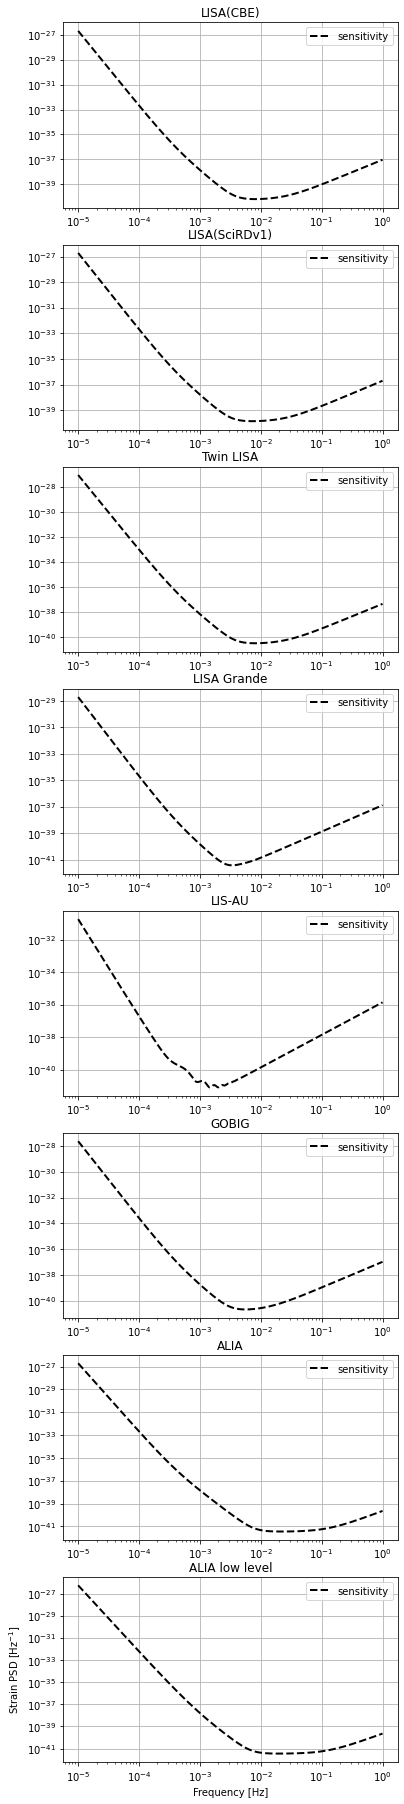

In [8]:
# sensitivity plot
#fig = plt.figure(figsize=(6,4),dpi=200)
f = np.logspace(-5,0,1000)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        ax.plot(ob.get('f')[1:],np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),linestyle='-',label=ob.get('source').get('label'))
    
    ax.plot(f,metrics.makeSensitivity(f,mission),color = 'black', linewidth=2.0,linestyle='--',label='sensitivity')
    ax.set_title(mission['label'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)

plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.subplots_adjust()
plt.savefig('../plots/%s_source_sensitvities.png' % 'all')

# Stuff from below here could be adapted from binaryResolutionSources, but has not been.

#### SNR as a function of time plot

No handles with labels found to put in legend.


<Figure size 1200x800 with 0 Axes>

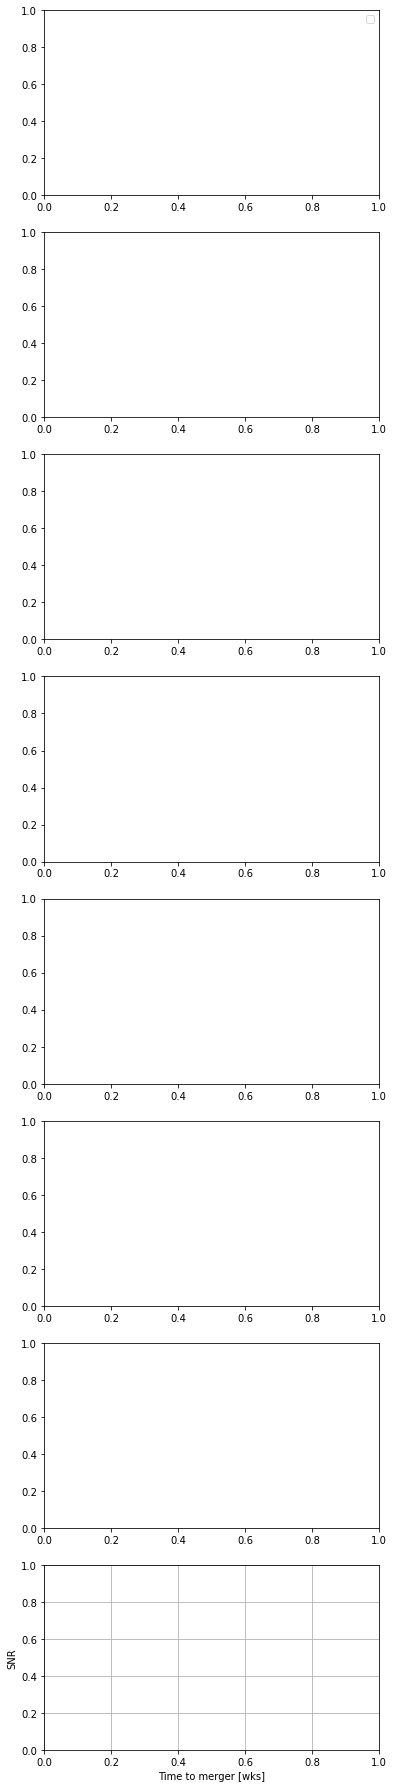

In [9]:
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
haveL=False
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        ax.plot(-ob.get('t')*52/constants.year,ob.get('SNR of t'),linestyle='-',label=ob.get('source').get('label'))
        ax.set_title(mission['label'])
        ax.set_xscale('linear')
        ax.set_yscale('log')
    if not haveL:
        ax.legend()
        haveL=True
#print(obs)
#plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
#plt.title(ob.get('source').get('label'))
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.subplots_adjust()
#plt.legend()
ax.grid(True)
#plt.savefig('../plots/%s_snr_v_t.png' % modelName)

#### Angular resolution as a function of time

No handles with labels found to put in legend.


<Figure size 1200x800 with 0 Axes>

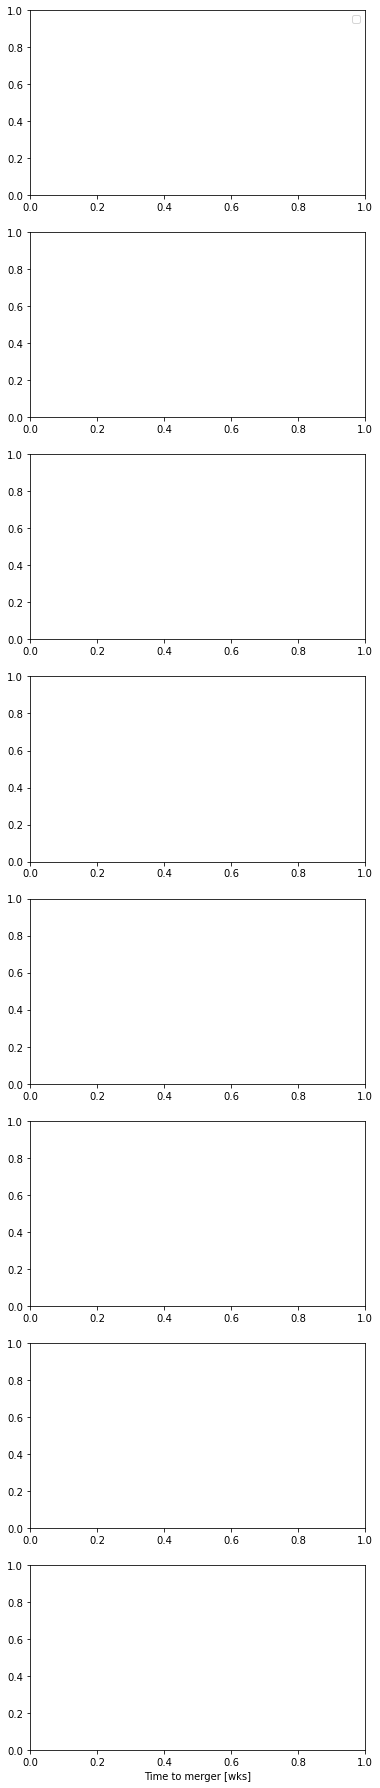

In [10]:
# Angular resolution
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
#ax = fig.add_subplot(1,1,1)
fig,axs=plt.subplots(len(missions),figsize=(6,4*len(missions)))
haveL=False
for i,mission in enumerate(missions):
    ax = axs[i]
    for ob in mission['obs']:
        if ob['source']['type']=='CW':continue
        if ob['assessment'].get('eps',10)>1:continue
        ax.plot(-ob.get('t')*52/constants.year,ob.get('Angular Resolution of t')*1e3,label= ob.get('source').get('label'))
        ax.set_title(mission['label'])
        ax.set_xscale('linear')
        ax.set_yscale('log')
        plt.ylabel('Astrometric Precision [mrad]')
    if not haveL:
        ax.legend()
        haveL=True
plt.xlabel('Time to merger [wks]')
plt.subplots_adjust()